In order to be able to run this notebook, please download and locate the folders `FR_d_Q12024` and `FR_d_Q12025` in the same directory (location) as this notebook.

Analysis on FR Q12024

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
from statsmodels.tsa.api import VAR

Load data

In [7]:
country = 'FR'
granularity = 'd'
period = 'Q12024'

folder = country+'_'+granularity+'_'+period
path = os.path.join(os.getcwd(),folder)

In [8]:
#price, exports and consumption
df_price24 = pd.read_csv(os.path.join(path, country+'_price_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)
df_export24 = pd.read_csv(os.path.join(path, country+'_exportschedule_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)
df_consumption24 = pd.read_csv(os.path.join(path, country+'_consumption_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)

df_price24.head()

,Date,TZ,FR Price Spot EUR/MWh EPEX H Actual,FR Price Spot Day-Ahead EUR/MWh H Backcast
0,2024-01-01 00:00,+01:00,13.14,17.30
1,2024-01-02 00:00,+01:00,36.19,39.93
2,2024-01-03 00:00,+01:00,46.11,47.31
3,2024-01-04 00:00,+01:00,78.98,69.28
4,2024-01-05 00:00,+01:00,90.54,85.48


In [12]:
#take only relevant columns
df_price_exp_cons24 = df_price24.copy()
df_price_exp_cons24['price'] = df_price24.iloc[:,2]
df_price_exp_cons24['net_exports'] = df_export24.iloc[:,2]
df_price_exp_cons24['consumption'] = df_consumption24.iloc[:,2]

df_price_exp_cons24['Date'] = pd.to_datetime(df_price_exp_cons24['Date'])

df_price_exp_cons24 = df_price_exp_cons24.iloc[:,[0,4,5,6]]
df_price_exp_cons24.insert(1, 'Day', df_price_exp_cons24['Date'].dt.date)

df_price_exp_cons24.head()

,Date,Day,price,net_exports,consumption
0,2024-01-01,2024-01-01,13.14,10174.08,49735.75
1,2024-01-02,2024-01-02,36.19,16979.16,55008.01
2,2024-01-03,2024-01-03,46.11,17280.33,55665.57
3,2024-01-04,2024-01-04,78.98,17367.00,56232.24
4,2024-01-05,2024-01-05,90.54,11318.74,57646.47


In [14]:
#production across sources
df_solar24 = pd.read_csv(os.path.join(path, country+'_solar_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)
df_wind24 = pd.read_csv(os.path.join(path, country+'_wind_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)
df_nuclear24 = pd.read_csv(os.path.join(path, country+'_nuclear_'+granularity+'_'+period+'.csv'),sep=';',skiprows=5)
df_naturalgas24 = pd.read_csv(os.path.join(path, country+'_naturalgas_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)
df_hardcoal24 = pd.read_csv(os.path.join(path, country+'_hardcoal_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)
df_hydroreservoir24 = pd.read_csv(os.path.join(path, country+'_hydroreservoir_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)
df_hydroriver24 = pd.read_csv(os.path.join(path, country+'_hydroriver_'+granularity+'_'+period+'.csv'),sep=';',skiprows=5)
df_hydropump24 = pd.read_csv(os.path.join(path, country+'_hydropump_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)

df_solar24.head()

,Date,TZ,FR Solar Photovoltaic Production MWh/h 30min Actual,FR Solar Photovoltaic Production MWh/h 15min Normal,FR Solar Photovoltaic Production MWh/h 15min Backcast
0,2024-01-01 00:00,+01:00,1071.52,1010.76,880.57
1,2024-01-02 00:00,+01:00,515.56,1018.05,399.47
2,2024-01-03 00:00,+01:00,787.35,1026.59,776.48
3,2024-01-04 00:00,+01:00,1190.31,1035.99,1218.13
4,2024-01-05 00:00,+01:00,708.90,1045.79,654.36


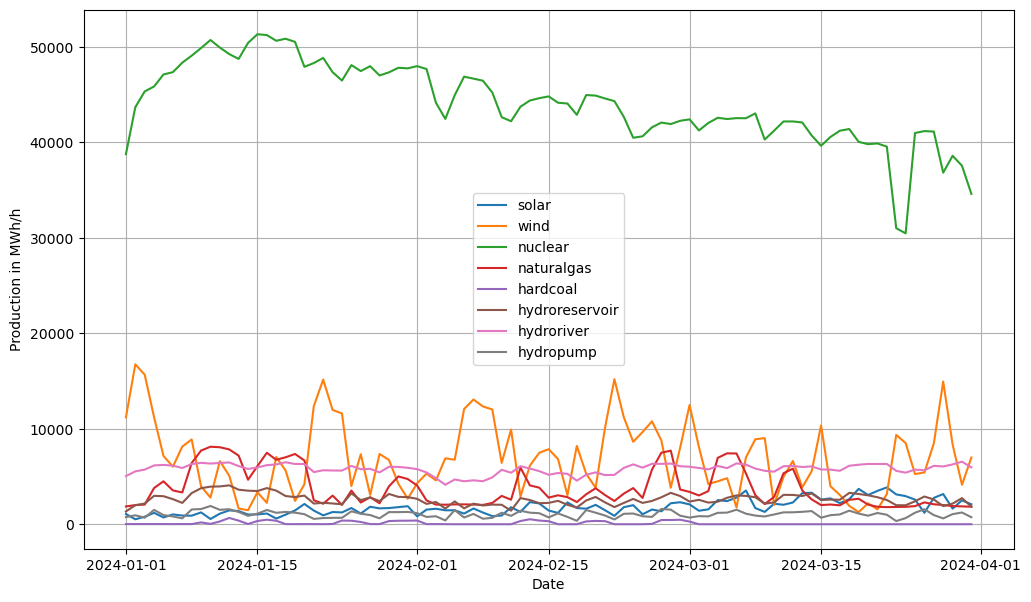

In [16]:
#compile df
df_production_MWh24 = df_solar24.copy()
df_production_MWh24 = df_production_MWh24.iloc[:,:1]

df_production_MWh24['solar'] = df_solar24.iloc[:,2]
df_production_MWh24['wind'] = df_wind24.iloc[:,2]
df_production_MWh24['nuclear'] = df_nuclear24.iloc[:,2]
df_production_MWh24['naturalgas'] = df_naturalgas24.iloc[:,2]
df_production_MWh24['hardcoal'] = df_hardcoal24.iloc[:,2]
df_production_MWh24['hydroreservoir'] = df_hydroreservoir24.iloc[:,2]
df_production_MWh24['hydroriver'] = df_hydroriver24.iloc[:,2]
df_production_MWh24['hydropump'] = df_hydropump24.iloc[:,2]

df_production_MWh24['Date'] = pd.to_datetime(df_production_MWh24['Date'])
df_production_MWh24.insert(1, 'Day', df_production_MWh24['Date'].dt.date)

#plot
plt.figure(figsize=(12,7))
for col in df_production_MWh24.columns[2:]:
    plt.plot(df_production_MWh24['Day'],df_production_MWh24[col],label=col)

plt.xlabel('Date')
plt.ylabel('Production in MWh/h')
plt.legend()
plt.grid(True)
plt.show()

The majority of electricity production in France was generated thanks to nuclear power in Q1 2024.

Repeat for 2025

In [20]:
#2025
period = 'Q12025'

folder = country+'_'+granularity+'_'+period
path = os.path.join(os.getcwd(),folder)

In [22]:
#price, exports and consumption
df_price25 = pd.read_csv(os.path.join(path, country+'_price_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)
df_export25 = pd.read_csv(os.path.join(path, country+'_exportschedule_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)
df_consumption25 = pd.read_csv(os.path.join(path, country+'_consumption_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)

In [24]:
#take only relevant columns
df_price_exp_cons25 = df_price25.copy()
df_price_exp_cons25['price'] = df_price25.iloc[:,2]
df_price_exp_cons25['net_exports'] = df_export25.iloc[:,2]
df_price_exp_cons25['consumption'] = df_consumption25.iloc[:,2]

df_price_exp_cons25['Date'] = pd.to_datetime(df_price_exp_cons25['Date'])
df_price_exp_cons25.set_index('Date', inplace=True)
df_price_exp_cons25 = df_price_exp_cons25.iloc[:,[3,4,5]]

As 2024 was a year with a 29 February and 2025 did not have any, in order to have the same number of day in the two quarters, we artificially create a fake 29 February 2025.

In [27]:
#create an artificial 29 February 2025 with interpolation
feb_29_fake = df_price_exp_cons25.loc["2025-02-28"].name + pd.Timedelta(hours=12)
df_price_exp_cons25.loc[feb_29_fake] = None
df_price_exp_cons25 = df_price_exp_cons25.sort_index()
df_price_exp_cons25 = df_price_exp_cons25.interpolate(method='time')

df_price_exp_cons25.reset_index(inplace=True)
df_price_exp_cons25.insert(1, 'Day', df_price_exp_cons25['Date'].dt.date)

In [29]:
#production across sources
df_solar25 = pd.read_csv(os.path.join(path, country+'_solar_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)
df_wind25 = pd.read_csv(os.path.join(path, country+'_wind_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)
df_nuclear25 = pd.read_csv(os.path.join(path, country+'_nuclear_'+granularity+'_'+period+'.csv'),sep=';',skiprows=5)
df_naturalgas25 = pd.read_csv(os.path.join(path, country+'_naturalgas_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)
df_hardcoal25 = pd.read_csv(os.path.join(path, country+'_hardcoal_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)
df_hydroreservoir25 = pd.read_csv(os.path.join(path, country+'_hydroreservoir_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)
df_hydroriver25 = pd.read_csv(os.path.join(path, country+'_hydroriver_'+granularity+'_'+period+'.csv'),sep=';',skiprows=5)
df_hydropump25 = pd.read_csv(os.path.join(path, country+'_hydropump_'+granularity+'_'+period+'.csv'),sep=';',skiprows=4)

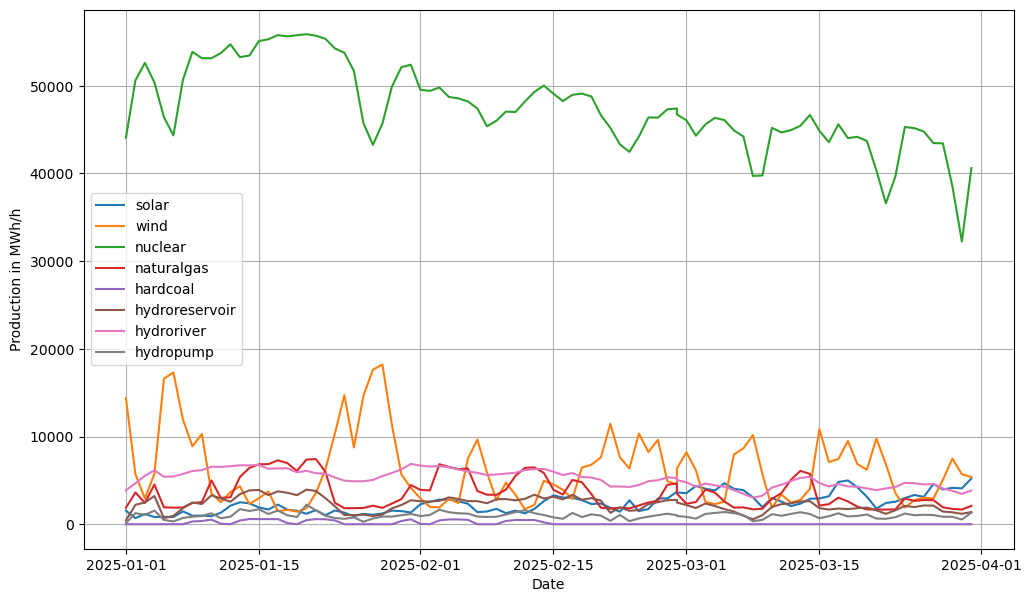

In [31]:
#compile df
df_production_MWh25 = df_solar25.copy()
df_production_MWh25 = df_production_MWh25.iloc[:,:1]

df_production_MWh25['solar'] = df_solar25.iloc[:,2]
df_production_MWh25['wind'] = df_wind25.iloc[:,2]
df_production_MWh25['nuclear'] = df_nuclear25.iloc[:,2]
df_production_MWh25['naturalgas'] = df_naturalgas25.iloc[:,2]
df_production_MWh25['hardcoal'] = df_hardcoal25.iloc[:,2]
df_production_MWh25['hydroreservoir'] = df_hydroreservoir25.iloc[:,2]
df_production_MWh25['hydroriver'] = df_hydroriver25.iloc[:,2]
df_production_MWh25['hydropump'] = df_hydropump25.iloc[:,2]

df_production_MWh25['Date'] = pd.to_datetime(df_production_MWh25['Date'])
#create an artificial 29 February 2025 with interpolation
df_production_MWh25.set_index('Date', inplace=True)
feb_29_fake = df_production_MWh25.loc["2025-02-28"].name + pd.Timedelta(hours=12)
df_production_MWh25.loc[feb_29_fake] = None
df_production_MWh25 = df_production_MWh25.sort_index()
df_production_MWh25 = df_production_MWh25.interpolate(method='time')

df_production_MWh25.reset_index(inplace=True)
df_production_MWh25.insert(1, 'Day', df_production_MWh25['Date'].dt.date)

#plot
plt.figure(figsize=(12,7))
for col in df_production_MWh25.columns[2:]:
    plt.plot(df_production_MWh25['Day'],df_production_MWh25[col],label=col)

plt.xlabel('Date')
plt.ylabel('Production in MWh/h')
plt.grid(True)
plt.legend()
plt.show()

<h2>EDA on Q1 2024</h2>

We first start by plotting the price of electricity to have an overview of the values it ranges in and its variation.

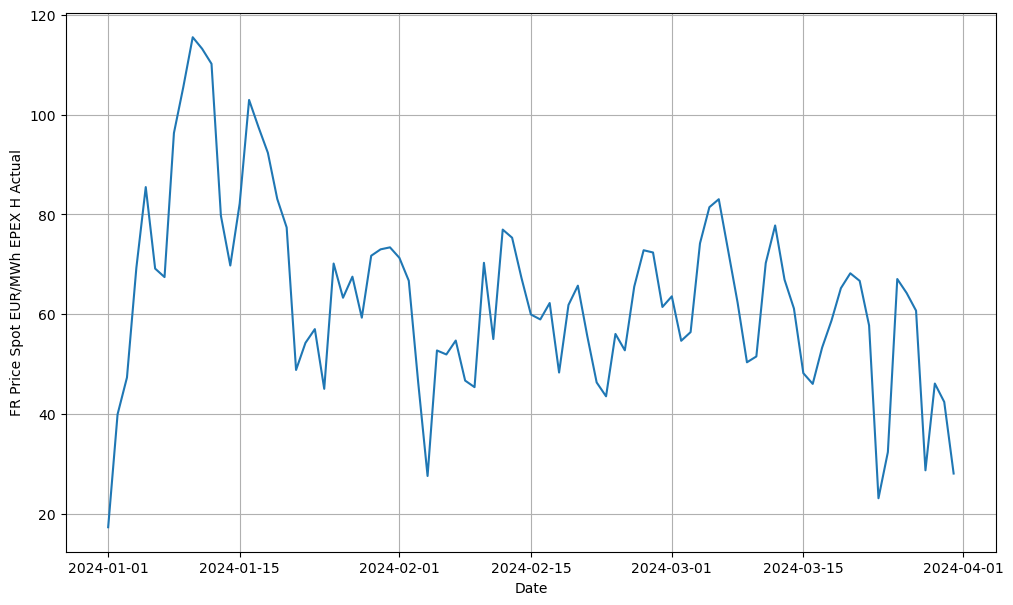

In [35]:
df_price_chart = df_price24.copy()
df_price_chart['Date'] = pd.to_datetime(df_price24['Date'])
df_price_chart.set_index('Date', inplace=True)
df_price_chart.index = df_price_chart.index.date

df_price_chart.iloc[:,2].plot(figsize=(12,7))
plt.xlabel('Date')
plt.ylabel(df_price_chart.columns[1])
plt.grid(True)
plt.show()

We sum the different sources of production of electricity and compare it to the total electricity consumption (the load). As we could expect, the difference between the total production and the net exports is matching the consumption. We could also see it the other way around. If the demand in France is lower/higher than the total production, then electricity has to be exported/imported.

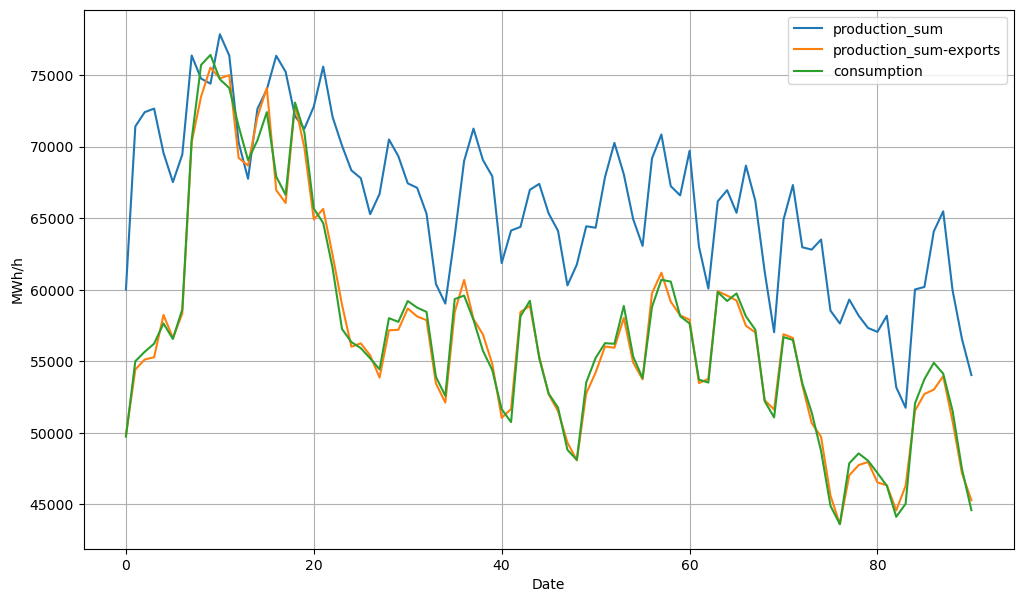

In [38]:
#Production minus net exports is equal to consumption
df_prodexp = df_production_MWh24.copy()
df_prodexp.set_index('Date', inplace=True)
df_prodexp = df_prodexp.iloc[:,1:]

df_prodexp['production_sum'] = df_prodexp.sum(axis=1)

df_prodexp.reset_index(inplace=True)
df_prodexp['production_sum-exports'] = df_prodexp['production_sum'] - df_price_exp_cons24['net_exports']
df_prodexp['consumption'] = df_price_exp_cons24['consumption']

df_prodexp.iloc[:,-3:].plot(figsize=(12,7))
plt.xlabel('Date')
plt.ylabel('MWh/h')
plt.grid(True)
plt.show()

The piece of information derived from the above chart is also important for the statistical analyses we will run afterwards. The above variable will indeed show collinearity if included together.  
For that reason, we will exclude consumption from the correlation matrix.

In [41]:
df_price_exp_prod = df_price_exp_cons24.copy()

df_price_exp_prod = df_price_exp_prod.iloc[:,:4]
df_price_exp_prod[df_production_MWh24.iloc[:,1:].columns] = df_production_MWh24.iloc[:,1:]

df_price_exp_prod.set_index('Date', inplace=True)
df_price_exp_prod = df_price_exp_prod.iloc[:,1:]
df_price_exp_prod.head()

,price,net_exports,solar,wind,nuclear,naturalgas,hardcoal,hydroreservoir,hydroriver,hydropump
Date,,,,,,,,,,
2024-01-01,13.14,10174.08,1071.52,11192.93,38751.34,1859.15,15.35,1339.22,5040.01,748.19
2024-01-02,36.19,16979.16,515.56,16741.96,43668.43,2003.96,15.46,1990.47,5534.97,936.19
2024-01-03,46.11,17280.33,787.35,15657.58,45318.77,2060.08,15.44,2162.43,5719.59,683.89
2024-01-04,78.98,17367.00,1190.31,11183.02,45842.86,3795.45,14.75,2972.27,6156.08,1498.29
2024-01-05,90.54,11318.74,708.90,7144.38,47098.71,4494.53,14.82,2934.21,6210.46,954.39


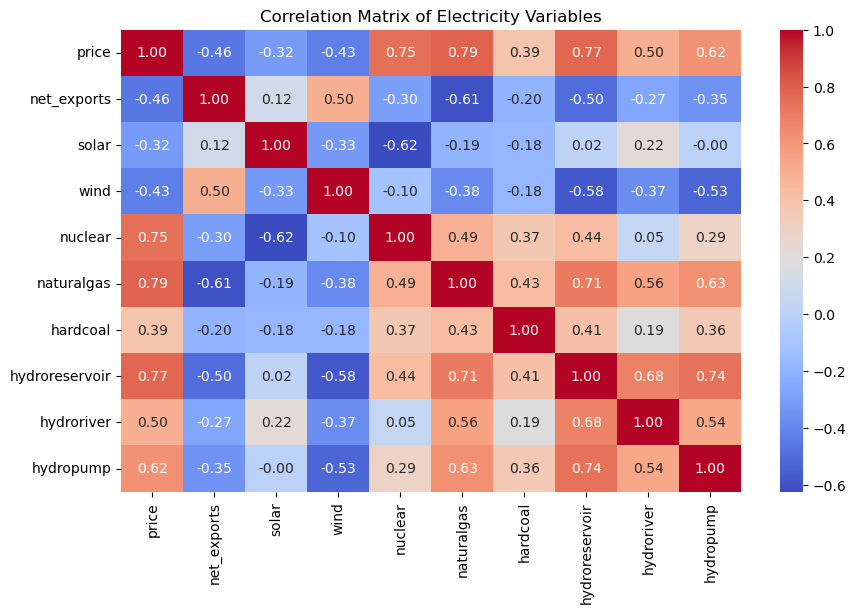

In [43]:
correlation_price_exp_prod = df_price_exp_prod.corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation_price_exp_prod, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Electricity Variables")
plt.show()

<h2>DiD</h2>

Given the lack of granular data on data centre energy consumption, and based on the literature review performed, we will estimate datacentre energy use.  
We start by loading data centre energy use in Europe in 2022, estimated by the European Commission.

In [47]:
#Data from EU report
baseline_EU = {
    'Country':['Germany','France','Netherlands','Ireland','Italy','Sweden','Spain','Poland','Belgium','Denmark','Austria','Finland','Czech Republic','Greece','Luxembourg','Portugal','Romania','Bulgaria','Hungary','Slovakia','Estonia','Croatia','Lithuania','Slovenia','Latvia','Cyprus','Malta'],
    '2022 data centres energy use (TWh)':[15.0,10.0,6.5,5.3,4.5,3.2,3.0,2.8,2.4,2.1,1.9,1.8,1.5,1.4,1.3,1.2,1.1,1.0,0.9,0.8,0.7,0.7,0.6,0.5,0.5,0.4,0.3]
}

df_baseline_EU = pd.DataFrame(baseline_EU)
df_baseline_EU['2022 data centres energy use (MWh)'] = 1000000*df_baseline_EU['2022 data centres energy use (TWh)']

df_baseline_EU.head()

,Country,2022 data centres energy use (TWh),2022 data centres energy use (MWh)
0,Germany,15.0,15000000.0
1,France,10.0,10000000.0
2,Netherlands,6.5,6500000.0
3,Ireland,5.3,5300000.0
4,Italy,4.5,4500000.0


Now that we have a baseline, we will apply a growth rate to have an estimate of data centre energy use in the years following 2022.

In [50]:
# Define growth rates based on the scenario
growth_scenarios = {
    'Baseline': 0.10,  # 10% CAGR
    'High Growth': 0.15,  # 15% CAGR
    'Low Growth': 0.05  # 5% CAGR
}

# Assign countries to each scenario
scenario_assignment = {
    'Baseline': ['Germany', 'France', 'Netherlands'],
    'High Growth': ['Ireland', 'Sweden', 'Denmark'],
    'Low Growth': ['Spain', 'Italy', 'Poland']
}

# Reverse mapping to assign the correct growth rate
country_growth_rate = {country: growth_scenarios[scenario] 
                       for scenario, countries in scenario_assignment.items() 
                       for country in countries}

# Default to low growth if a country isn't explicitly listed
default_growth_rate = growth_scenarios['Low Growth']

# Start from baseline
df_datacentre_y = df_baseline_EU.iloc[:, :1].copy()
df_datacentre_y['2022'] = df_baseline_EU['2022 data centres energy use (MWh)']

# Apply growth rates
for year in range(2023, 2026):
    df_datacentre_y[str(year)] = df_datacentre_y.apply(
        lambda row: row[str(year - 1)] * (1 + country_growth_rate.get(row['Country'], default_growth_rate)), 
        axis=1
    )

df_datacentre_y.head()

,Country,2022,2023,2024,2025
0,Germany,15000000.0,16500000.0,18150000.0,19965000.0
1,France,10000000.0,11000000.0,12100000.0,13310000.0
2,Netherlands,6500000.0,7150000.0,7865000.0,8651500.0
3,Ireland,5300000.0,6095000.0,7009250.0,8060637.5
4,Italy,4500000.0,4725000.0,4961250.0,5209312.5


In [52]:
#Distribute evenly datacentre consumption in Q1 2024
filtered_value = df_datacentre_y.loc[df_datacentre_y['Country'] == 'France', '2024']
df_price_exp_cons24['data_centre'] = filtered_value.values[0]/365/24

filtered_value = df_datacentre_y.loc[df_datacentre_y['Country'] == 'France', '2025']
df_price_exp_cons25['data_centre'] = filtered_value.values[0]/365/24

df_price_exp_cons24.head()

,Date,Day,price,net_exports,consumption,data_centre
0,2024-01-01,2024-01-01,13.14,10174.08,49735.75,1381.278539
1,2024-01-02,2024-01-02,36.19,16979.16,55008.01,1381.278539
2,2024-01-03,2024-01-03,46.11,17280.33,55665.57,1381.278539
3,2024-01-04,2024-01-04,78.98,17367.00,56232.24,1381.278539
4,2024-01-05,2024-01-05,90.54,11318.74,57646.47,1381.278539


In [54]:
#add binary indicator for Q12025
df_price_exp_cons24['Post2025'] = 0
df_price_exp_cons25['Post2025'] = 1

df_price_exp_cons24.set_index('Date', inplace=True)
df_price_exp_cons25.set_index('Date', inplace=True)
df_production_MWh24.set_index('Date', inplace=True)
df_production_MWh25.set_index('Date', inplace=True)

df_combined1 = pd.concat([df_price_exp_cons24.iloc[:,1:],df_production_MWh24.iloc[:,1:]], axis=1)
df_combined2 = pd.concat([df_price_exp_cons25.iloc[:,1:],df_production_MWh25.iloc[:,1:]], axis=1)
df_combined = pd.concat([df_combined1,df_combined2])
df_combined = df_combined.sort_index()

#create interaction term
df_combined['Post2025xDatacentre'] = df_combined['Post2025']*df_combined['data_centre']

df_combined.head()

,price,net_exports,consumption,data_centre,Post2025,solar,wind,nuclear,naturalgas,hardcoal,hydroreservoir,hydroriver,hydropump,Post2025xDatacentre
Date,,,,,,,,,,,,,,
2024-01-01,13.14,10174.08,49735.75,1381.278539,0,1071.52,11192.93,38751.34,1859.15,15.35,1339.22,5040.01,748.19,0.0
2024-01-02,36.19,16979.16,55008.01,1381.278539,0,515.56,16741.96,43668.43,2003.96,15.46,1990.47,5534.97,936.19,0.0
2024-01-03,46.11,17280.33,55665.57,1381.278539,0,787.35,15657.58,45318.77,2060.08,15.44,2162.43,5719.59,683.89,0.0
2024-01-04,78.98,17367.00,56232.24,1381.278539,0,1190.31,11183.02,45842.86,3795.45,14.75,2972.27,6156.08,1498.29,0.0
2024-01-05,90.54,11318.74,57646.47,1381.278539,0,708.90,7144.38,47098.71,4494.53,14.82,2934.21,6210.46,954.39,0.0


We perform the DiD regression with a simple interaction term and consumption as a control variable. Adding each production variable does not improve the model's adj. R² and it causes collinearity issues. We hence choose this simple model.

In [59]:
#run DiD Regression
X = df_combined[['Post2025xDatacentre','consumption']]
X = sm.add_constant(X)
y = df_combined['price']
model1 = sm.OLS(y,X).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     163.7
Date:                Mon, 19 May 2025   Prob (F-statistic):           3.73e-41
Time:                        16:04:13   Log-Likelihood:                -814.40
No. Observations:                 182   AIC:                             1635.
Df Residuals:                     179   BIC:                             1644.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -107.4214    

In [61]:
# Check for multicollinearity since the condition number is large
X_check = df_combined[['Post2025xDatacentre','consumption']]
vif_data = pd.DataFrame()
vif_data['Variable'] = X_check.columns
vif_data['VIF'] = [variance_inflation_factor(X_check.values, i) for i in range(len(X_check.columns))]
print(vif_data)

              Variable       VIF
0  Post2025xDatacentre  2.076988
1          consumption  2.076988


Significant coefficients and VIF under threshold of 10. We can validate the model.  

<h3>Visualizations</h3>

Since our DiD model suggests a stronger impact of data centres on prices in Q1 2025, let’s compare price distributions between the two periods.

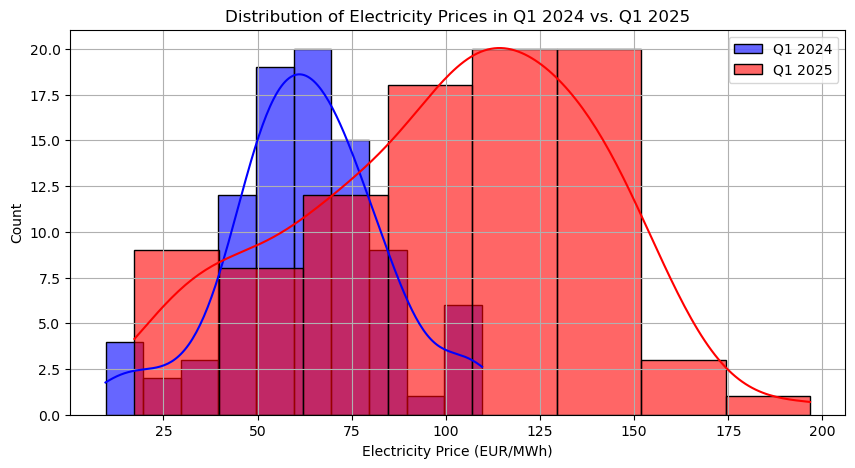

In [66]:
plt.figure(figsize=(10, 5))
sns.histplot(df_combined[df_combined["Post2025"] == 0]["price"], kde=True, color="blue", label="Q1 2024", alpha=0.6)
sns.histplot(df_combined[df_combined["Post2025"] == 1]["price"], kde=True, color="red", label="Q1 2025", alpha=0.6)
plt.xlabel("Electricity Price (EUR/MWh)")
plt.title("Distribution of Electricity Prices in Q1 2024 vs. Q1 2025")
plt.legend()
plt.grid()
plt.show()

The chart confirms that electricity prices were generally higher in Q1 2025. The wider spread we can observe in Q1 2025 also suggests more volatility.

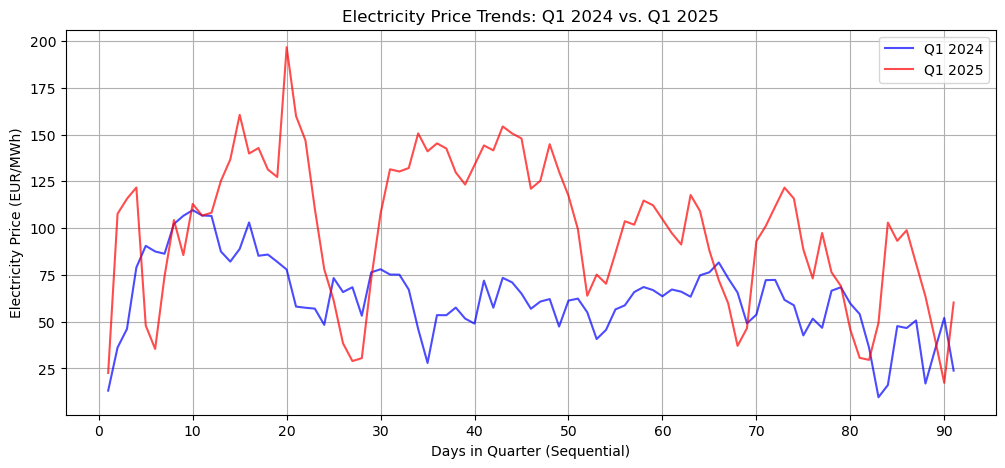

In [69]:
# Create a sequential day index for each dataset
df_2024 = df_combined[df_combined["Post2025"] == 0].copy()
df_2025 = df_combined[df_combined["Post2025"] == 1].copy()

df_2024["day_index"] = range(1, len(df_2024) + 1)
df_2025["day_index"] = range(1, len(df_2025) + 1)

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_2024["day_index"], df_2024["price"], label="Q1 2024", color="blue", alpha=0.7)
plt.plot(df_2025["day_index"], df_2025["price"], label="Q1 2025", color="red", alpha=0.7)

# Labels and title
plt.xlabel("Days in Quarter (Sequential)")
plt.ylabel("Electricity Price (EUR/MWh)")
plt.title("Electricity Price Trends: Q1 2024 vs. Q1 2025")
plt.xticks(range(0, len(df_2024) + 1, 10))  # Show every 10 days
plt.legend()
plt.grid()
plt.show()

This chart confirms the findings of our DiD. Prices were generally higher in 2025 with more volatility.

<h3>Statistical tests</h3>

In [73]:
# Extract prices for each period
prices_2024 = df_combined[df_combined["Post2025"] == 0]["price"]
prices_2025 = df_combined[df_combined["Post2025"] == 1]["price"]

# Perform independent t-test
t_stat, p_value = ttest_ind(prices_2024, prices_2025, equal_var=False)
print(f"T-statistic: {t_stat:.2f}, P-value: {p_value:.4f}")

T-statistic: -8.11, P-value: 0.0000


checks if the mean electricity price significantly changed between Q1 2024 and Q1 2025. p-value < 0.05, the difference in prices is statistically significant.

In [76]:
mean_price_2024 = df_combined[df_combined["Post2025"] == 0]["price"].mean()
mean_price_2025 = df_combined[df_combined["Post2025"] == 1]["price"].mean()

price_diff = mean_price_2025 - mean_price_2024
print(f"Mean Price Difference: {price_diff:.2f} EUR/MWh")

# Predict prices using the model
df_combined["predicted_price"] = model1.predict()

# Compute mean predicted prices for Q1 2024 and Q1 2025
predicted_price_2024 = df_combined[df_combined["Post2025"] == 0]["predicted_price"].mean()
predicted_price_2025 = df_combined[df_combined["Post2025"] == 1]["predicted_price"].mean()

adjusted_price_diff = predicted_price_2025 - predicted_price_2024
print(f"Regression-Adjusted Price Difference: {adjusted_price_diff:.2f} EUR/MWh")

Mean Price Difference: 36.96 EUR/MWh
Regression-Adjusted Price Difference: 36.96 EUR/MWh


**Mean Price Difference** calculates the simple difference in average electricity prices between Q1 2024 and Q1 2025 without controlling for any factors. It includes all sources of variation (e.g., changes in data centre electricity demand, total electricity consumption, generation mix, policy changes).  
**Regression-Adjusted Price Difference** predicts what prices "should have been" using the regression model. As the model controls for variations in electricity consumption and data centre electricity demand and not any other factor, it is essentially what prices "should have been" if only electricity consumption and data centre electricity demand were taken into account.

We get the same price difference. This suggests that data centre electricity consumption and total demand were the key drivers of price changes, and no other major unmodeled factors were responsible.

Key finding: data centre energy consumption had a bigger impact on prices in Q1 2025 than Q1 2024.

<h2>Production</h2>

In [81]:
corr_2024 = df_combined[df_combined["Post2025"] == 0][["price", "consumption"]].corr().iloc[0, 1]
corr_2025 = df_combined[df_combined["Post2025"] == 1][["price", "consumption"]].corr().iloc[0, 1]

print(f"Correlation between Price and Consumption (Q1 2024): {corr_2024:.2f}")
print(f"Correlation between Price and Consumption (Q1 2025): {corr_2025:.2f}")

Correlation between Price and Consumption (Q1 2024): 0.75
Correlation between Price and Consumption (Q1 2025): 0.76


In both years, electricity prices were strongly correlated with total consumption, with only a slight increase in correlation in Q1 2025 (0.75 → 0.76). This subtle shift indicates that supply-side influences—such as changes in the generation mix or policy adjustments—may have played a somewhat diminished role in price formation, with consumption (including data centre consumption) emerging as the dominant driver.

<h2>VAR</h2>

Consider Data centre consumption as part of total consumption. We then shift focus and look at consumption only. Let's try to see how consumption has impacted price formation depending on the energy mix.

Hypothesis: we want to show that consumption (including data centre consumption) does not have the same impact on prices if we are in a renewables setting or nuclear setting.  
We will apply a shock in consumption and see how the model reacts.

In [87]:
df_combined2.head()

,price,net_exports,consumption,data_centre,Post2025,solar,wind,nuclear,naturalgas,hardcoal,hydroreservoir,hydroriver,hydropump
Date,,,,,,,,,,,,,
2025-01-01,22.59,5848.46,58704.27,1519.406393,1,1551.00,14379.35,44064.15,1876.99,0.0,430.42,3860.90,128.98
2025-01-02,107.69,6329.61,61612.92,1519.406393,1,699.15,5712.83,50614.24,3617.08,0.0,2214.64,4672.01,1262.91
2025-01-03,115.69,2776.84,64733.80,1519.406393,1,1163.54,2924.62,52609.97,2428.23,0.0,2481.38,5527.61,1068.06
2025-01-04,121.74,9269.50,64887.52,1519.406393,1,821.54,5757.02,50373.35,4520.75,0.0,3220.07,6148.80,1549.09
2025-01-05,47.95,16093.95,55693.09,1519.406393,1,834.81,16591.62,46425.36,1927.45,0.0,705.11,5414.41,495.07


In [89]:
df_all_25 = df_combined2.copy()
#keep all variables except those related to datacentre use
df_all_25 = df_all_25.iloc[:,[0,1,2,5,6,7,8,9,10,11,12]]
#remove the interpolation for 29 February
df_all_25 = df_all_25.drop(pd.to_datetime('2025-02-28 12:00:00'))

df_all_25.head()

,price,net_exports,consumption,solar,wind,nuclear,naturalgas,hardcoal,hydroreservoir,hydroriver,hydropump
Date,,,,,,,,,,,
2025-01-01,22.59,5848.46,58704.27,1551.00,14379.35,44064.15,1876.99,0.0,430.42,3860.90,128.98
2025-01-02,107.69,6329.61,61612.92,699.15,5712.83,50614.24,3617.08,0.0,2214.64,4672.01,1262.91
2025-01-03,115.69,2776.84,64733.80,1163.54,2924.62,52609.97,2428.23,0.0,2481.38,5527.61,1068.06
2025-01-04,121.74,9269.50,64887.52,821.54,5757.02,50373.35,4520.75,0.0,3220.07,6148.80,1549.09
2025-01-05,47.95,16093.95,55693.09,834.81,16591.62,46425.36,1927.45,0.0,705.11,5414.41,495.07


In [91]:
#run ADF test on each column
for col in df_all_25.columns:
    result = adfuller(df_all_25[col])
    print(f"{col}: p-value = {result[1]:.4f}")

price: p-value = 0.1415
net_exports: p-value = 0.0001
consumption: p-value = 0.9504
solar: p-value = 0.9225
wind: p-value = 0.0002
nuclear: p-value = 0.8693
naturalgas: p-value = 0.0096
hardcoal: p-value = 0.2287
hydroreservoir: p-value = 0.0173
hydroriver: p-value = 0.8271
hydropump: p-value = 0.0005


Stationarity testing with ADF

`price`,`consumption`, `solar`, `nuclear`, `hardcoal` and `hydroriver` are the variables with a p-value exceding 0.05, hence the only non-stationary variables. We will differentiate them to make them stationary.

In [95]:
df_stationary = df_all_25.copy()

for col in df_all_25.columns:
    result = adfuller(df_all_25[col])
    if result[1] > 0.05:
        df_stationary[col] = df_all_25[col].diff()

# Drop rows with NaN after differencing
df_stationary.dropna(inplace=True)

Group variables and add interaction terms

In [98]:
df_stationary["renewables"] = (df_stationary["solar"] + df_stationary["wind"]) 
df_stationary["controllable"] = (df_stationary["nuclear"] + df_stationary["hydroreservoir"] + df_stationary["hydroriver"] + df_stationary["hydropump"] + df_stationary["naturalgas"] + df_stationary["hardcoal"])

df_stationary["renewables_share"] = df_stationary["renewables"] / (df_stationary["renewables"] + df_stationary["controllable"])
df_stationary["controllable_share"] = df_stationary["controllable"] / (df_stationary["renewables"] + df_stationary["controllable"])

df_stationary["consumption_x_renewables"] = df_stationary["consumption"] * df_stationary["renewables_share"]
df_stationary["consumption_x_controllable"] = df_stationary["consumption"] * df_stationary["controllable_share"]

In [100]:
df_stationary.head()

,price,net_exports,consumption,solar,wind,nuclear,naturalgas,hardcoal,hydroreservoir,hydroriver,hydropump,renewables,controllable,renewables_share,controllable_share,consumption_x_renewables,consumption_x_controllable
Date,,,,,,,,,,,,,,,,,
2025-01-02,85.10,6329.61,2908.65,-851.85,5712.83,6550.09,3617.08,0.0,2214.64,811.11,1262.91,4860.98,14455.83,0.251645,0.748355,731.947432,2176.702568
2025-01-03,8.00,2776.84,3120.88,464.39,2924.62,1995.73,2428.23,0.0,2481.38,855.60,1068.06,3389.01,8829.00,0.277378,0.722622,865.664174,2255.215826
2025-01-04,6.05,9269.50,153.72,-342.00,5757.02,-2236.62,4520.75,0.0,3220.07,621.19,1549.09,5415.02,7674.48,0.413692,0.586308,63.592717,90.127283
2025-01-05,-73.79,16093.95,-9194.43,13.27,16591.62,-3947.99,1927.45,0.0,705.11,-734.39,495.07,16604.89,-1554.75,1.103305,-0.103305,-10144.257712,949.827712
2025-01-06,-12.51,9599.88,3488.07,-15.16,17302.79,-2082.86,1889.15,0.0,949.92,32.38,315.09,17287.63,1103.68,0.939989,0.060011,3278.747603,209.322397


In [102]:
selected_vars = ["price", "consumption_x_renewables", "consumption_x_controllable"]
df_var2 = df_stationary[selected_vars]

df_var2.head()

,price,consumption_x_renewables,consumption_x_controllable
Date,,,
2025-01-02,85.10,731.947432,2176.702568
2025-01-03,8.00,865.664174,2255.215826
2025-01-04,6.05,63.592717,90.127283
2025-01-05,-73.79,-10144.257712,949.827712
2025-01-06,-12.51,3278.747603,209.322397


Optimal lag selection with AIC

In [105]:
model = VAR(df_var2)
lag_order = model.select_order(maxlags=3)
print(lag_order.summary())
optimal_lag = lag_order.aic

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      36.09*      36.18*  4.719e+15*      36.12*
1       36.24       36.59   5.502e+15       36.38
2       36.20       36.80   5.251e+15       36.44
3       36.19       37.05   5.224e+15       36.53
-------------------------------------------------


C:\Users\pacog\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [107]:
#force lag 2
var_results = model.fit(2)
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 19, May, 2025
Time:                     16:06:08
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    36.7600
Nobs:                     87.0000    HQIC:                   36.4045
Log likelihood:          -1922.51    FPE:                5.08891e+15
AIC:                      36.1648    Det(Omega_mle):     4.03458e+15
--------------------------------------------------------------------
Results for equation price
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                -2.150292         2.730648           -0.787           0.431
L1.price                              0.173485         0.144733            1.199           0.

IRF

In [110]:
irf = var_results.irf(10)

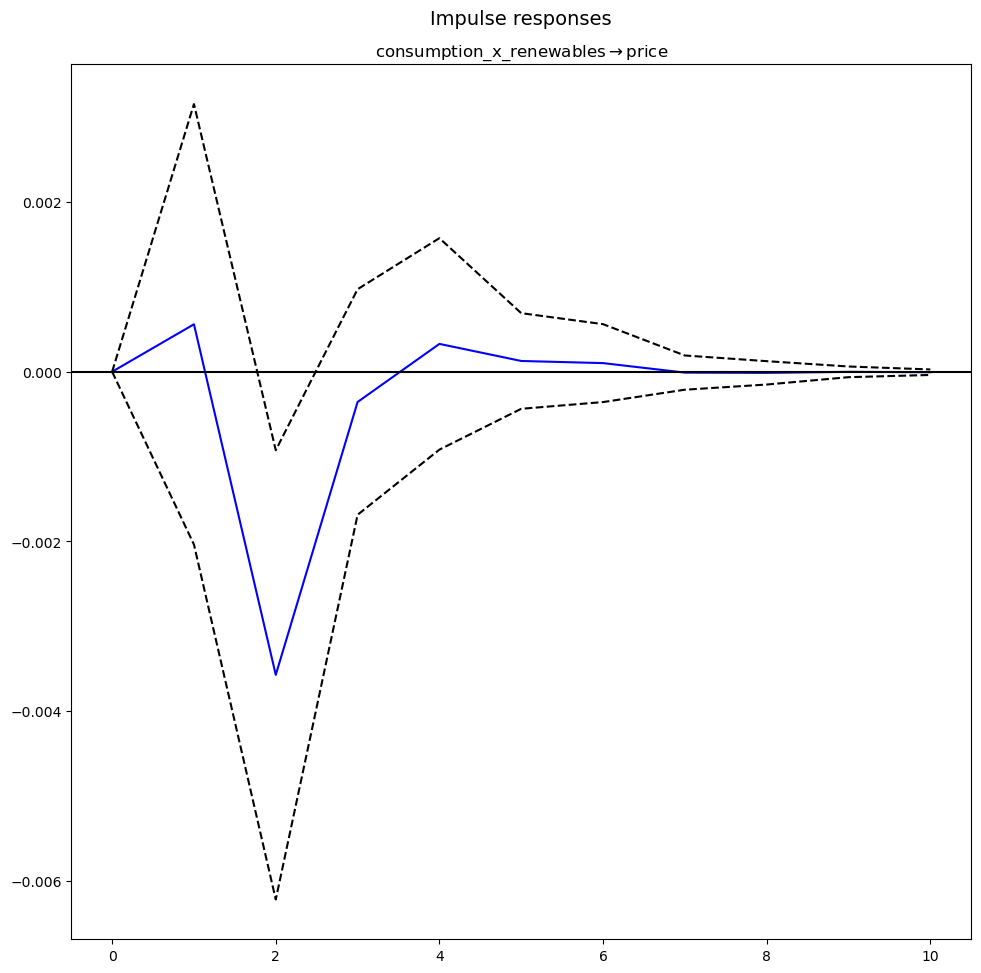

In [112]:
fig1 = irf.plot(impulse='consumption_x_renewables', response='price')

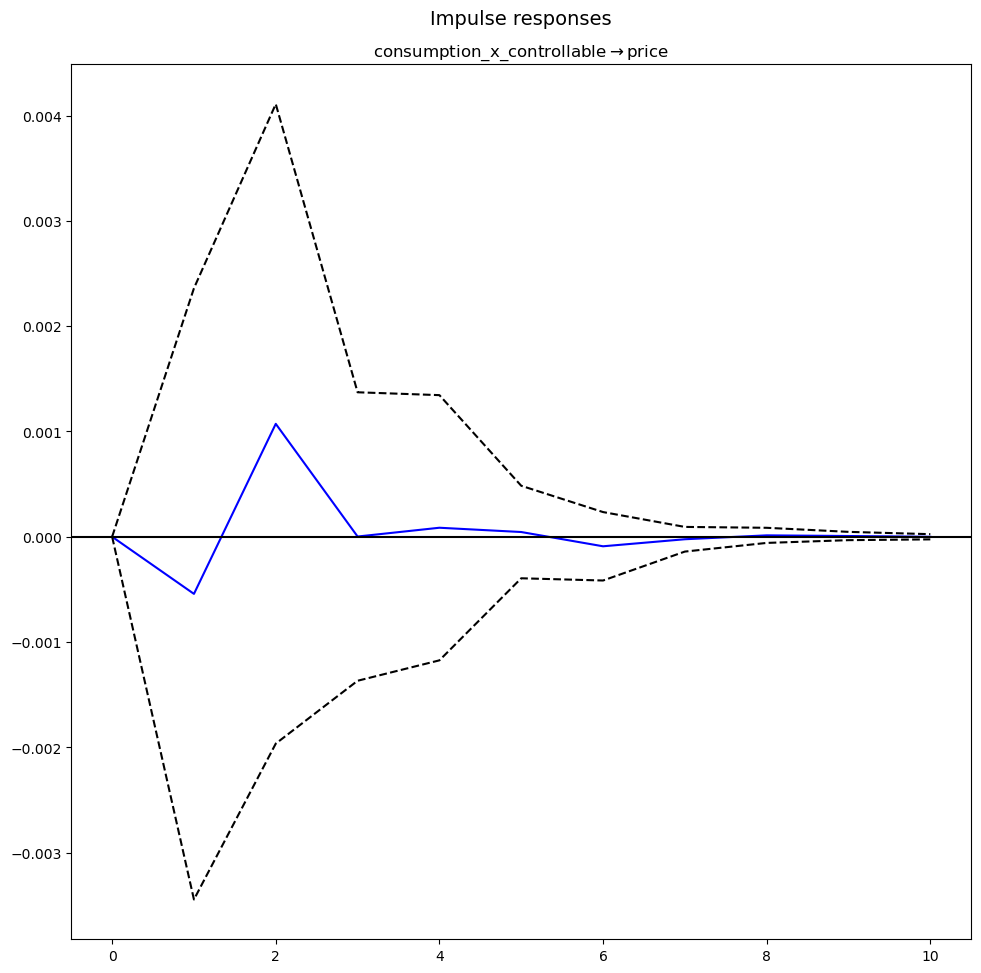

In [114]:
fig2 = irf.plot(impulse='consumption_x_controllable', response='price')